# Climate Change and Impacts in Africa

According to the United Nations, Climate change refers to long-term shifts in temperatures and weather patterns. Such shifts can be natural, due to changes in the sun’s activity or large volcanic eruptions. But since the 1800s, human activities have been the main driver of climate change, primarily due to the burning of fossil fuels like coal, oil, and gas.

The consequences of climate change now include, among others, intense droughts, water scarcity, severe fires, rising sea levels, flooding, melting polar ice, catastrophic storms, and declining biodiversity.

The dataset [IEA-EDGAR CO2 dataset](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117) contains three sheets - IPCC 2006, 1PCC 1996, and TOTALS BY COUNTRY on the amount of CO2 (a greenhouse gas) generated by countries between 1970 and 2021.


### TOTALS BY COUNTRY SHEET

This sheet contains the annual CO2 (kt) produced between 1970 - 2021 in each country. The relevant columns in this sheet are:

| Columns | Description |
| ------- | ------------|
| C_group_IM24_sh | The region of the world |
| Country_code_A3 | The country code |
| Name            | The name of the country |
| Y_1970 - Y_2021 | The amount of CO2 (kt) from 1970 - 2021 |


### IPCC 2006

These sheets contain the amount of CO2 by country and the industry responsible. 

| Columns | Description |
| ------- | ------------|
| C_group_IM24_sh | The region of the world |
| Country_code_A3 | The country code |
| Name            | The name of the country |
| Y_1970 - Y_2021 | The amount of CO2 (kt) from 1970 - 2021 |
| ipcc_code_2006_for_standard_report_name | The industry responsible for generating CO2 |

## Questions



1. Clean and tidy the datasets. 
2. Create a line plot to show the trend of CO2 levels across the African regions.
3. Determine the relationship between time (Year) and CO2 levels across the African regions.
4. Determine if there is a significant difference in the CO2 levels among the African Regions.
5. Determine the most common (top 5) industries in each African region.
6. Determine the industry responsible for the most amount of CO2 (on average) in each African Region.
7. Predict the CO2 levels (at each African region) in the year 2025.
8. Determine if CO2 levels affect annual temperature in the selected African countries.



In [43]:
# Setup
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

plt.style.use('ggplot')
# The sheet names containing our datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11
# Let's skip the first 10 rows
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# we need only the African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')


# Read the temperatures datasets containing four African countries
# One from each African Region:
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')

## 1. Clean and tidy the datasets



- Rename C_group_IM24_sh to Region, Country_code_A3 to Code, and ipcc_code_2006_for_standard_report_name to Industry in the corresponding African datasets.
- Drop IPCC_annex, ipcc_code_2006_for_standard_report, and Substance from the corresponding datasets.
- Melt Y_1970 to Y_2021 into a two columns Year and CO2. Drop rows where CO2 is missing.
- Convert Year to int type.



In [45]:
#Rename columns
#ipcc_2006_africa table
ipcc_2006_africa.rename(columns={"C_group_IM24_sh": "Region", "ipcc_code_2006_for_standard_report_name" : "Industry", "Country_code_A3" : "Code"}, inplace=True)

#totals_by_country_afric table
totals_by_country_africa.rename(columns={"C_group_IM24_sh": "Region", "ipcc_code_2006_for_standard_report_name" : "Industry", "Country_code_A3" : "Code"}, inplace=True)


#Drop columns
#ipcc_2006_africa table
ipcc_2006_africa.drop(columns=["IPCC_annex","ipcc_code_2006_for_standard_report","Substance" ],inplace=True)

#totals_by_country_africa
totals_by_country_africa.drop(columns={"IPCC_annex", "Substance"}, inplace=True)

#Create a function that melts required columns
def melt(df):
    # extract all columns name starting with 'Y_'
    name=df.columns[df.columns.str.startswith('Y_')]
    # extract column name not starting with "Y_"
    name2=list(df.columns.difference(name))
    # melt the dataframe
    melt=df.melt(id_vars=name2, value_vars=name, var_name='Year', value_name='CO2')
    # extract only rows where 'CO2'  column is null
    melt=melt[~melt['CO2'].isnull()]
    # Replace 'Y_' with '' to convert year to int
    melt['Year']=melt['Year'].str.replace('Y_', '').astype(int)   
     
    return melt

# APPLY THE FUNCTION TO DATAFRAMES
ipcc_2006_africa=melt(ipcc_2006_africa)
totals_by_country_africa=melt(totals_by_country_africa)

display(ipcc_2006_africa.head())
display(totals_by_country_africa.head())

,Code,Industry,Name,Region,fossil_bio,Year,CO2
0,AGO,Manufacturing Industries and Construction,Angola,Southern_Africa,bio,1970,468.101210
1,AGO,Residential and other sectors,Angola,Southern_Africa,bio,1970,9803.605447
3,AGO,Emissions from biomass burning,Angola,Southern_Africa,bio,1970,1168.997514
4,AGO,Main Activity Electricity and Heat Production,Angola,Southern_Africa,fossil,1970,137.584287
5,AGO,Petroleum Refining - Manufacture of Solid Fuel...,Angola,Southern_Africa,fossil,1970,74.805080


,Code,Name,Region,Year,CO2
0,AGO,Angola,Southern_Africa,1970,20393.274068
1,BDI,Burundi,Eastern_Africa,1970,4385.562636
2,BEN,Benin,Western_Africa,1970,4318.786819
3,BFA,Burkina Faso,Western_Africa,1970,8158.106987
4,BWA,Botswana,Southern_Africa,1970,947.246888


## 2. Show the trend of CO2 levels across the African regions



- Using totals_by_country_africa, create a line plot of CO2 vs. Year in each Region to show the trend of CO2 levels by year.



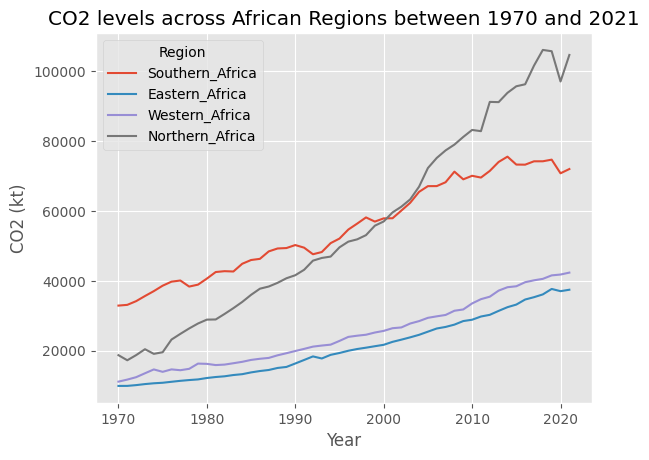

In [48]:
# Lineplot
import seaborn as sns

plt.style.use('ggplot')
sns.lineplot(data=totals_by_country_africa, x="Year", y="CO2", hue="Region", ci=None)
plt.title("CO2 levels across African Regions between 1970 and 2021")
plt.xlabel("Year")
plt.ylabel("CO2 (kt)")
plt.show()


## 3. Determine the relationship between time (Year) and CO2 levels across the African regions



- Using the totals_by_country_africa dataset, conduct a Spearman's correlation to determine the relationship between time (Year) and CO2 within each African Region.
- Save the results in a variable called relationship_btw_time_CO2.




In [50]:
# Correlation

relationship_btw_time_CO2 = totals_by_country_africa.groupby('Region')[['Year', 'CO2']].corr(method='spearman')

display(relationship_btw_time_CO2.head())

Year       CO2
Region                                  
Eastern_Africa  Year  1.000000  0.181768
                CO2   0.181768  1.000000
Northern_Africa Year  1.000000  0.429875
                CO2   0.429875  1.000000
Southern_Africa Year  1.000000  0.260986

## 4. Determine if there is a significant difference in the CO2 levels among the African Regions


- Using totals_by_country_africa, conduct an ANOVA using pingouin.anova() on the CO2 by Region. Save the results as aov_results.
- Conduct a posthoc test (with Bonferroni correction) using pingouin.pairwise_tests() to find the source of the significant difference. Save the results as pw_ttest_result.

In [53]:
# aov_results
aov_results= pingouin.anova(data=totals_by_country_africa, dv='CO2', between='Region')

#pw_ttest_result
pw_ttest_result= pingouin.pairwise_tests(data=totals_by_country_africa, dv="CO2", between="Region", padjust="bonf")

display(aov_results.head())
display(pw_ttest_result.head())

,Source,ddof1,ddof2,F,p-unc,np2
0,Region,3,2908,35.558065,1.455509e-22,0.035385


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Region,Eastern_Africa,Northern_Africa,False,True,-9.435557,388.384101,two-sided,3.637966e-19,2.182780e-18,bonf,1.554e+17,-0.801390
1,Region,Eastern_Africa,Southern_Africa,False,True,-6.814718,641.441785,two-sided,2.180575e-11,1.308345e-10,bonf,4.024e+08,-0.421846
2,Region,Eastern_Africa,Western_Africa,False,True,-1.556846,1917.149304,two-sided,1.196721e-01,7.180324e-01,bonf,0.173,-0.059094
3,Region,Northern_Africa,Southern_Africa,False,True,0.080513,881.040358,two-sided,9.358475e-01,1.000000e+00,bonf,0.079,0.004785
4,Region,Northern_Africa,Western_Africa,False,True,7.588964,567.964972,two-sided,1.328970e-13,7.973818e-13,bonf,9.641e+10,0.418029


## 5. Determine the most common (top 5) industries in each African region.


- Group the ipcc_2006_africa data by Region and Industry.
- Count the occurrences of each Industry within each Region and name it Count.
- Sort the data within each region group by Count in descending order
- Get the top 5 industries for each region
- save it to variable top_5_industries for each region.


In [56]:
# Group data and count
Grouped= ipcc_2006_africa.groupby(['Region', 'Industry']).size().reset_index(name='Count')

# sort grouped data
Grouped = Grouped.sort_values(['Region', 'Count'], ascending=[True, False])

# Get top 5 industries
top_5_industries = Grouped.groupby('Region').head(5).reset_index(drop=True)

display(top_5_industries.head())

,Region,Industry,Count
0,Eastern_Africa,Residential and other sectors,1454
1,Eastern_Africa,Manufacturing Industries and Construction,1383
2,Eastern_Africa,Main Activity Electricity and Heat Production,1174
3,Eastern_Africa,Road Transportation no resuspension,742
4,Eastern_Africa,Glass Production,728


## 6. Determine the industry responsible for the most amount of CO2 (on average) in each African Region


- Group the ipcc_2006_africa data by Region and Industry.
- Calculate the average CO2 emissions for each group.
- Find the Industry with the maximum average CO2 emissions in each region.



In [59]:
# Group ipcc_2006_africa
Grouped = ipcc_2006_africa.groupby(['Region', 'Industry'])['CO2'].mean().reset_index()

# Average CO2 emissions
max_co2_industries = Grouped.loc[Grouped.groupby('Region')['CO2'].idxmax()].reset_index(drop=True)

# Industry with max CO2
max_co2_industries = Grouped.loc[Grouped.groupby('Region')['CO2'].idxmax()].reset_index(drop=True)

display(max_co2_industries)

,Region,Industry,CO2
0,Eastern_Africa,Residential and other sectors,7904.439282
1,Northern_Africa,Main Activity Electricity and Heat Production,13612.230148
2,Southern_Africa,Main Activity Electricity and Heat Production,11377.802504
3,Western_Africa,Residential and other sectors,8702.936136


## 7. Predict the CO2 levels (at each African region) in the year 2025


- Create an instance of LinearRegression() and save it as reg.
- Fit a linear model of CO2 (in log base 10) by Year and Region using reg.fit().
- Predict the values of CO2 using the reg.predict() and the data provided. Save the result as predicted_co2. 
- Convert predicted_co2 values from log base 10 to decimals and round to 2 d.p using np.round().




In [62]:

newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)
reg= LinearRegression()

target = np.log10(totals_by_country_africa['CO2'])
feats = pd.get_dummies(totals_by_country_africa[['Year', 'Region']])
reg.fit(feats, target)
predicted_CO2 = reg.predict(newdata)
predicted_CO2 = np.round(10**predicted_CO2, 2)

display(predicted_CO2)

array([15177.72, 10788.07, 37761.69, 41081.9 ])

## 8. Determine if CO2 levels affect annual temperature in the selected African countries




- Select Name, Year and CO2 of countries countries. Save the result as selected_countries.
- Convert temperatures dataset from wide to long format. Set the new column names to Name and Temperature. Save the result as temp_long.
- Perform an inner join between selected_countries and temp_long on Name and Year. Save the result as joined.
- Create a linear model of Temperature by CO2 and Name. Save the result as model_temp. 
- A one unit rise in log10 CO2 leads to how many degrees rise in temperature? Run model_temp.summary() to find out!
- What is the adjusted R squared value of the model?


In [52]:

countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]

selected_countries = totals_by_country_africa[['Name', 'Year', 'CO2']].query('Name in @countries')

temp_long =temperatures.melt(id_vars=['Year'], value_vars=countries, var_name='Name', value_name='Temperature')

joined = pd.merge(selected_countries, temp_long, on=['Name', 'Year'], how='inner')


model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3066.
Date:                Wed, 23 Aug 2023   Prob (F-statistic):          8.89e-175
Time:                        14:51:15   Log-Likelihood:                -53.064
No. Observations:                 200   AIC:                             116.1
Df Residuals:                     195   BIC:                             132.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.3471      0.629     21.211      0.000      12.106      14.588
Name[T.Mozambique]     2.1036      0.096     21.921      0.000       1.914       2.293
Name[T.Nigeria]        2.8114      0.097     29.117      0.000       2.621       3.002
Name[T.Tunisia]       -1.6058      0.109    -14.734      0.000      -1.821      -1.391
np.log10(CO2)          1.9774      0.126     15.683      0.000       1.729       2.226
==============================================================================
Omnibus:                        3.179   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.925
Skew:                          -0.294   Prob(JB):                        0.232
Kurtosis:                       3.075   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Insights

- Based on the line plot analysis, Northern Africa has the highest CO2 emissions of over 100,000(kt), closely followed by Southern Africa with almost 80,000(kt). Western and Eastern Africa have been releasing CO2 at a more average rate over the years.
- The Spearman's correlation coefficient measures the strength and direction of the relationship between two variables. In this case, for Eastern Africa, the correlation between Year and CO2 is 0.1818, which suggests a weak positive relationship. For Northern Africa, the correlation is 0.4299, indicating a moderate positive relationship. And for Southern Africa, the correlation is 0.261, also suggesting a weak positive relationship
- Based on the ANOVA test results, the p-value of 1.455509291e-22 suggests that there is a significant difference in CO2 levels among the regions. Therefore, it is not true that the CO2 levels of the Southern Africa and Northern Africa regions do not differ significantly.
- To be precise, in every region of Africa, the top industries consist of Residential and other sectors, Manufacturing Industries and Construction, Main Activity Electricity and Heat Production, Road Transportation no resuspension, and Glass Production
- In Eastern and Western Africa, the Residential and other sectors industry contributes the highest amount of CO2 emissions. On the other hand, in Northern and Southern Africa, the Main Activity Electricity and Heat Production industry is responsible for the majority of CO2 emissions.
- Based on my prediction, the CO2 levels in each African region for the year 2025 are as follows:
  Eastern Africa: 15,177.72, Northern Africa: 10,788.07, Southern Africa: 37,761.69, Western Africa: 41,081.90. These values represent the estimated CO2 levels in each region for the year 2025 based on your prediction.
- Based on the OLS regression results, the R-squared value of 0.984 suggests that CO2 levels have a strong effect on annual temperature in the selected African countries. The coefficients for the CO2 variable are all statistically significant (p < 0.001), indicating a positive relationship between CO2 levels and temperature. The intercept and country-specific coefficients also contribute to the overall model.